In [1]:
import tensorflow as tf
import os
import math
import time
import pickle
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
CIFAR_DIR = "./cifar-10-batches-py/"
#print (os.listdir(CIFAR_DIR))
#bat_data, bat_labels = cifar10_input.distorted_inputs(data_dir=CIFAR_DIR,batch_size=20)
#print(bat_data)

In [2]:
def load_data(filename):
    """read data from data file."""
    with open(filename,'rb') as f:
        data = pickle.load(f,encoding='bytes')
        #print(data[b'data'][1])
        #print(data.shape)
        return data[b'data'],data[b'labels']
def weight_variable(shape,stddev):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)
def bias_variable(shape,value):
    initial = tf.constant(value=value,shape=shape)
    return tf.Variable(initial)
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x,name):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME',name = name)

def norm_lrn(x,name):
    return tf.nn.lrn(x, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name=name)
def loss_acc_curve(step,loss,acc,num):
    #step = np.linspace(step[0], step[num], 10) 
    #loss = np.linspace(step[0], loss[num], 10)    
    #acc = np.linspace(step[0], acc[num], 10)    
    plt.plot(step, loss,'-',label="loss")
    plt.plot(step, acc,'-',label="acc")

    plt.title('loss_acc')
    plt.xlabel('step')
    plt.ylabel('loss_acc')
    plt.savefig('./loss_acc/loss_acc_AlexNet',dpi=600)  
    plt.show()
    
    plt.plot(acc, loss,'-',label="loss-acc")
    plt.title('loss-acc')
    plt.xlabel('acc')
    plt.ylabel('loss')
    plt.savefig('./loss_acc/loss-acc_AlexNet',dpi=600)  
    plt.show()
    
    

In [3]:
def sort_image_real(num):
    if num == 1:
        x = '小汽车'
    elif num == 2:
        x = '鸟类'
    elif num == 3:
        x = '猫'
    elif num == 4:
        x = '鹿'
    elif num == 5:
        x = '狗'
    elif num == 6:
        x = '青蛙'
    elif num == 7:
        x = '马'
    elif num == 8:
        x = '船'
    elif num ==9:
        x = '卡车'
    elif num == 0:
        x = '飞机'
    else :
        x = 'error'
    return x
        


In [4]:
class CifarData:
    def __init__(self,filenames,need_shuffle):
        all_data = []
        all_labels = []
        
        for filename in filenames:
            data,labels = load_data(filename)
            print(data.shape)
            all_data.append(data)
            
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        #print(all_data[1])
        #print(data[1])
        self._image = self._data
        self._data = self._data / 127.5 -1
        
        self._labels = np.hstack(all_labels)
        '''print (self._data.shape)
        print (self._labels.shape)
        '''
        self._num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def _shuffle_data(self):
        #[0,1,2,3,4,5]-> [5,3,2,4,0,1]
        p = np.random.permutation(self._num_examples)
        self._data = self._data[p]
        self._labels = self._labels[p]
        
    def next_batch(self,batch_size):
        """return batch_size examples as a batch."""
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples  ")
        if end_indicator > self._num_examples:
            raise Exception("batch size is larger than all examples")
        batch_image = self._image[self._indicator: end_indicator]
        batch_data = self._data[self._indicator: end_indicator]
        #batch_data = self._data[end_indicator]
        #print(self._data[end_indicator])
        #print('######################################')
        #print(self._data[self._indicator: end_indicator])
        #print(batch_data)
        #print(batch_data.shape)
        batch_labels = self._labels[self._indicator: end_indicator]
        #batch_labels = self._labels[end_indicator]
        self._indicator = end_indicator
        return batch_image,batch_data,batch_labels

                            



In [5]:
train_filenames = [os.path.join(CIFAR_DIR, 'data_batch_%d.bin' % i) for i in range(1,6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch.bin')]

train_data = CifarData(train_filenames,True)
test_data = CifarData(test_filenames,False)

(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)


In [10]:
batch_size = 128
x = tf.placeholder(tf.float32,[None,3072])
x_image = tf.reshape(x, [batch_size,32,32,3])
keep_prob  = tf.placeholder(tf.float32)
y = tf.placeholder(tf.int64,[None])
#[CONV->POOL]
W_conv1_1 = weight_variable([5, 5, 3, 96],0.05)
b_conv1_1 = bias_variable([96],0.0)
bias_add1 = tf.nn.bias_add(conv2d(x_image, W_conv1_1) ,b_conv1_1)
h_conv1_1 = tf.nn.relu(bias_add1,name = "h_conv1_1") 
h_pool1 = max_pool_2x2(h_conv1_1,"h_pool1")
norm1 = norm_lrn(h_pool1,"norm1")
#[CONV->POOL]
W_conv2= weight_variable([3,3, 96, 256],0.05)
b_conv2 = bias_variable([256],0.1)
bias_add2_1 = tf.nn.bias_add(conv2d(norm1, W_conv2) ,b_conv2)
h_conv2_1 = tf.nn.relu(bias_add2_1,name = "h_conv2_1")
#bias_add2_2 = tf.nn.bias_add(conv2d(h_conv2_1, W_conv2) ,b_conv2)
#h_conv2_2 = tf.nn.relu(bias_add2_2,name = "h_conv2_2")
norm2 = norm_lrn(h_conv2_1,"norm2")
h_pool2 = max_pool_2x2(norm2,"h_pool2")

#[CONV*3->POOL]
W_conv3_1= weight_variable([3,3, 256, 384],0.05)
b_conv3_1 = bias_variable([384],0.1)
bias_add3_1 = tf.nn.bias_add(conv2d(h_pool2, W_conv3_1) ,b_conv3_1)
h_conv3_1 = tf.nn.relu(bias_add3_1,name = "h_conv3_1")
W_conv3_2= weight_variable([3,3, 384, 384],0.05)
b_conv3_2 = bias_variable([384],0.1)
bias_add3_2 = tf.nn.bias_add(conv2d(h_conv3_1, W_conv3_2) ,b_conv3_2)
h_conv3_2 = tf.nn.relu(bias_add3_2,name = "h_conv2_2")
W_conv3_3= weight_variable([3,3, 384, 256],0.05)
b_conv3_3 = bias_variable([256],0.1)
bias_add3_3 = tf.nn.bias_add(conv2d(h_conv3_2, W_conv3_3) ,b_conv3_3)
h_conv3_3 = tf.nn.relu(bias_add3_3,name = "h_conv2_2")
norm3 = norm_lrn(h_conv3_3,"norm2")
h_pool3 = max_pool_2x2(norm3,"h_pool2")


#[FC1]
print (h_pool3)
norm_flat = tf.reshape(h_pool3, [batch_size, -1])
print(norm_flat)
dim = norm_flat.get_shape()[1].value
print(dim)
W_fc1 = weight_variable([dim,4096],0.04)
b_fc1 = bias_variable([4096],0.1)
h_fc1 = tf.nn.relu(tf.matmul(norm_flat, W_fc1) + b_fc1,name ="h_fc1")
h_fc1_drop = tf.nn.dropout(h_fc12,keep_prob)

print(h_fc1)
#[FC2] 
W_fc2 = weight_variable([4096,4096],0.04)
b_fc2 = bias_variable([4096],0.1)
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2,name ="h_fc2")
h_fc2_drop = tf.nn.dropout(h_fc2,keep_prob)
#[outpout]
W_fc3 = weight_variable([4096,10],1/192.0)
b_fc3 = bias_variable([10],0.1)
y_ = tf.add(tf.matmul(h_fc2_drop, W_fc3), b_fc3, name="y_")

print(x_image)
print(y_)
loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
#y_ -> sofmax
#y -> one_hot
#loss = ylogy_
#bool
image_prediction = tf.argmax(y_,1)
# [1,#0,1,1,1,0,0,0]
correct_prediction = tf.equal(image_prediction,y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float64))
top_k_op = tf.nn.in_top_k(y_, y, 1)
with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
    ema = tf.train.ExponentialMovingAverage(decay=0.9999)
    with tf.control_dependencies([train_op]):
        optimize_op = ema.apply(tf.trainable_variables())


Tensor("h_pool2_3:0", shape=(128, 4, 4, 256), dtype=float32)
Tensor("Reshape_3:0", shape=(128, 4096), dtype=float32)
4096


NameError: name 'h_fc12' is not defined

step 100, loss=1.84 (29.7 examples/sec; 4.307 sec/batch),acc: 0.34375
step 200, loss=1.70 (29.7 examples/sec; 4.305 sec/batch),acc: 0.39062
step 300, loss=1.59 (29.8 examples/sec; 4.299 sec/batch),acc: 0.41406
step 400, loss=1.47 (29.9 examples/sec; 4.276 sec/batch),acc: 0.50000
step 500, loss=1.54 (29.8 examples/sec; 4.292 sec/batch),acc: 0.46875
step 600, loss=1.52 (29.9 examples/sec; 4.279 sec/batch),acc: 0.45312
step 700, loss=1.65 (29.7 examples/sec; 4.317 sec/batch),acc: 0.46094
step 800, loss=1.20 (29.6 examples/sec; 4.328 sec/batch),acc: 0.54688
step 900, loss=1.33 (30.3 examples/sec; 4.224 sec/batch),acc: 0.51562
step 1000, loss=1.38 (30.2 examples/sec; 4.242 sec/batch),acc: 0.45312
step 1100, loss=1.17 (30.1 examples/sec; 4.251 sec/batch),acc: 0.57812
step 1200, loss=1.19 (28.2 examples/sec; 4.543 sec/batch),acc: 0.57031
step 1300, loss=1.04 (17.6 examples/sec; 7.270 sec/batch),acc: 0.61719
step 1400, loss=1.28 (17.9 examples/sec; 7.156 sec/batch),acc: 0.51562
step 1500, loss

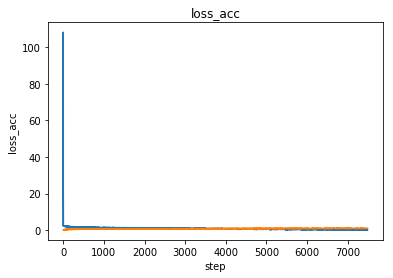

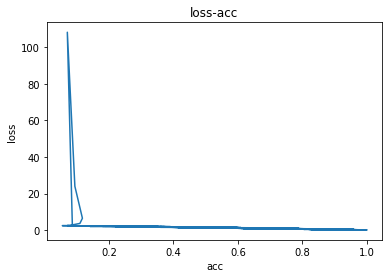

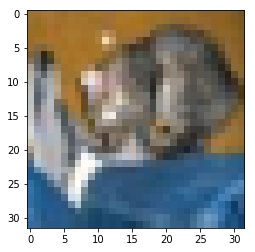

acc: 0.54688
[Test] Step:1 预测分类是 猫，真实分类是 猫


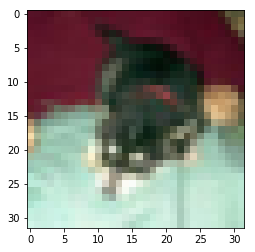

acc: 0.57031
[Test] Step:2 预测分类是 猫，真实分类是 狗


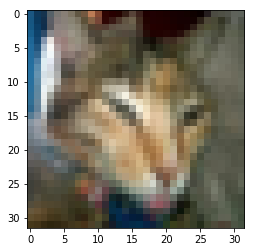

acc: 0.65625
[Test] Step:3 预测分类是 狗，真实分类是 猫


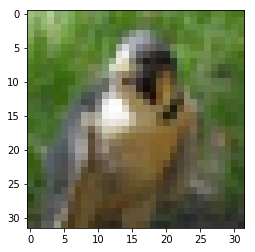

acc: 0.59375
[Test] Step:4 预测分类是 狗，真实分类是 鸟类


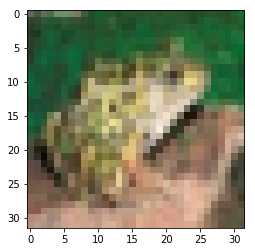

acc: 0.69531
[Test] Step:5 预测分类是 青蛙，真实分类是 青蛙


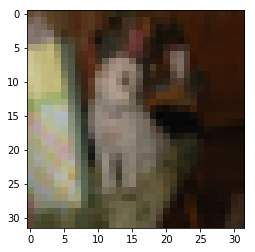

acc: 0.66406
[Test] Step:6 预测分类是 猫，真实分类是 狗


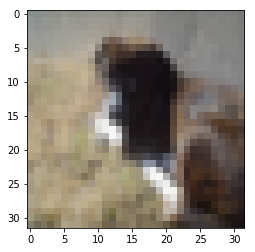

acc: 0.66406
[Test] Step:7 预测分类是 狗，真实分类是 狗


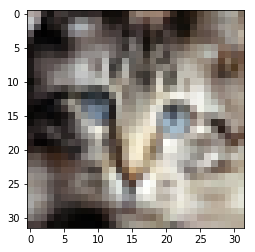

acc: 0.67188
[Test] Step:8 预测分类是 猫，真实分类是 猫


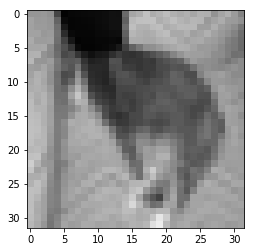

acc: 0.63281
[Test] Step:9 预测分类是 狗，真实分类是 猫


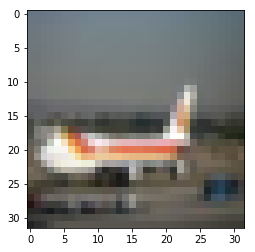

acc: 0.58594
[Test] Step:10 预测分类是 飞机，真实分类是 飞机


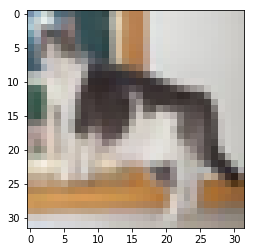

acc: 0.57812
[Test] Step:11 预测分类是 狗，真实分类是 猫


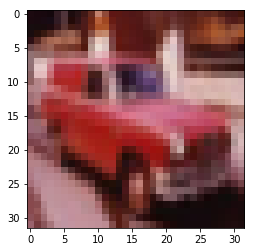

acc: 0.63281
[Test] Step:12 预测分类是 小汽车，真实分类是 小汽车


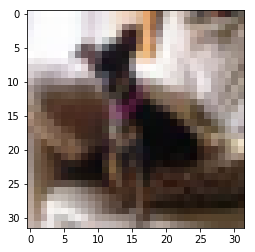

acc: 0.55469
[Test] Step:13 预测分类是 鸟类，真实分类是 狗


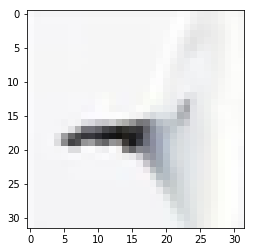

acc: 0.61719
[Test] Step:14 预测分类是 飞机，真实分类是 飞机


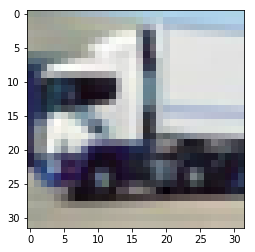

acc: 0.67969
[Test] Step:15 预测分类是 卡车，真实分类是 卡车


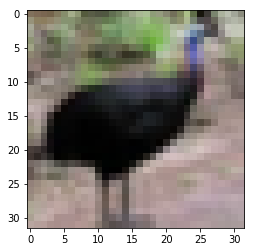

acc: 0.51562
[Test] Step:16 预测分类是 鸟类，真实分类是 鸟类


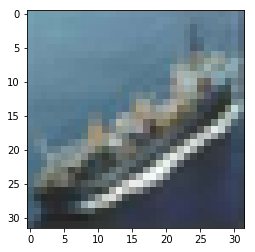

acc: 0.63281
[Test] Step:17 预测分类是 船，真实分类是 船


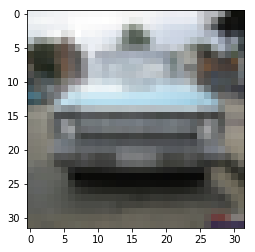

acc: 0.67188
[Test] Step:18 预测分类是 船，真实分类是 小汽车


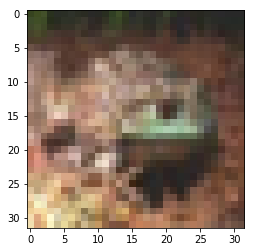

acc: 0.60938
[Test] Step:19 预测分类是 青蛙，真实分类是 青蛙


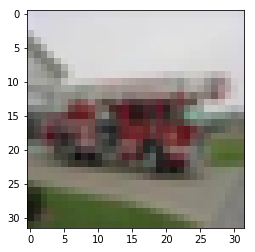

acc: 0.57031
[Test] Step:20 预测分类是 飞机，真实分类是 卡车


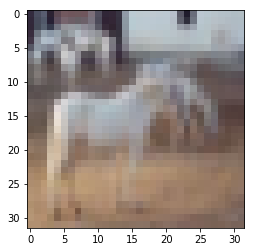

acc: 0.66406
[Test] Step:21 预测分类是 马，真实分类是 马


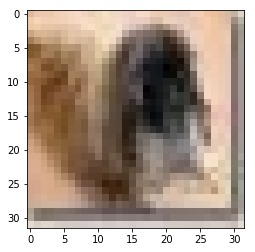

acc: 0.64062
[Test] Step:22 预测分类是 猫，真实分类是 狗


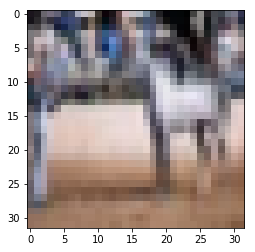

acc: 0.70312
[Test] Step:23 预测分类是 马，真实分类是 马


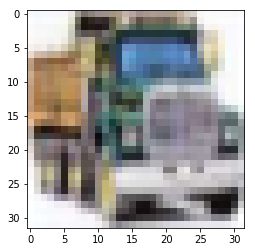

acc: 0.62500
[Test] Step:24 预测分类是 小汽车，真实分类是 卡车


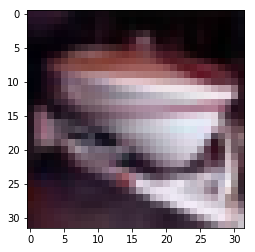

acc: 0.64844
[Test] Step:25 预测分类是 猫，真实分类是 船


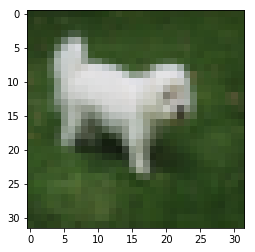

acc: 0.60938
[Test] Step:26 预测分类是 狗，真实分类是 狗


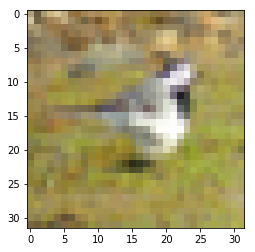

acc: 0.57031
[Test] Step:27 预测分类是 鸟类，真实分类是 鸟类


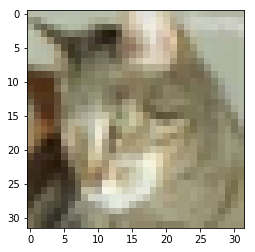

acc: 0.69531
[Test] Step:28 预测分类是 猫，真实分类是 猫


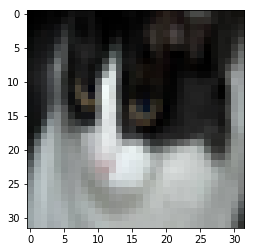

acc: 0.64062
[Test] Step:29 预测分类是 狗，真实分类是 猫


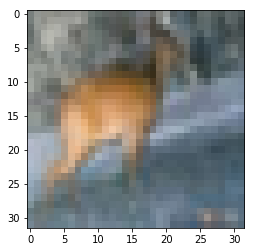

acc: 0.64062
[Test] Step:30 预测分类是 鹿，真实分类是 鹿


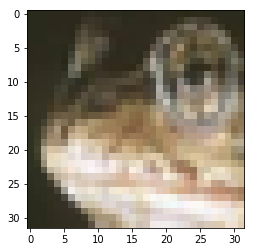

acc: 0.64062
[Test] Step:31 预测分类是 猫，真实分类是 青蛙


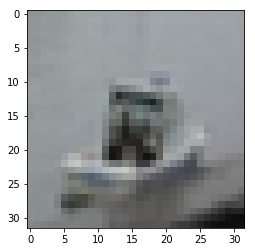

acc: 0.69531
[Test] Step:32 预测分类是 鸟类，真实分类是 船


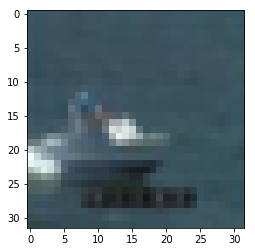

acc: 0.72656
[Test] Step:33 预测分类是 船，真实分类是 船


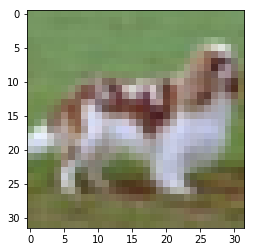

acc: 0.69531
[Test] Step:34 预测分类是 狗，真实分类是 狗


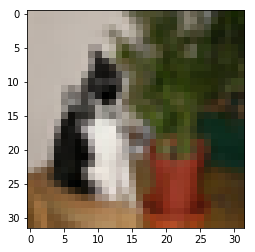

acc: 0.60156
[Test] Step:35 预测分类是 猫，真实分类是 猫


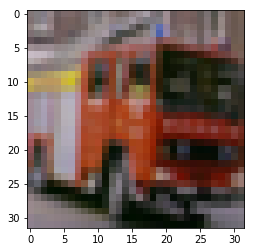

acc: 0.62500
[Test] Step:36 预测分类是 卡车，真实分类是 卡车


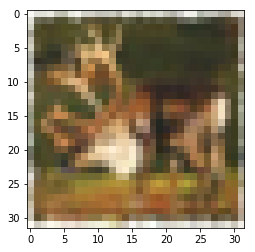

acc: 0.71094
[Test] Step:37 预测分类是 鹿，真实分类是 鹿


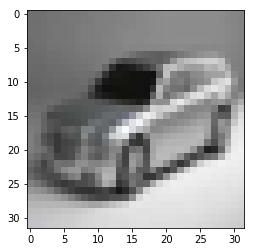

acc: 0.64062
[Test] Step:38 预测分类是 小汽车，真实分类是 小汽车


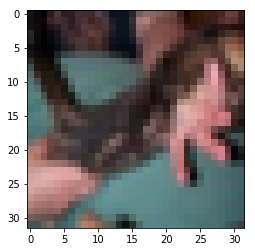

acc: 0.63281
[Test] Step:39 预测分类是 鹿，真实分类是 猫


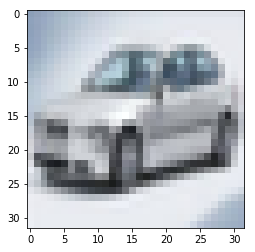

acc: 0.63281
[Test] Step:40 预测分类是 小汽车，真实分类是 小汽车


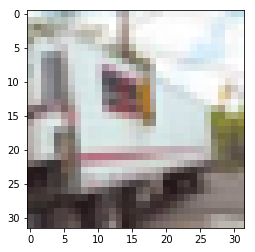

acc: 0.64062
[Test] Step:41 预测分类是 猫，真实分类是 卡车


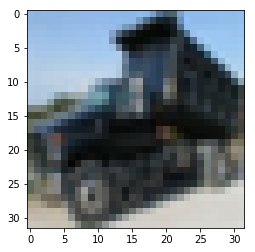

acc: 0.62500
[Test] Step:42 预测分类是 卡车，真实分类是 卡车


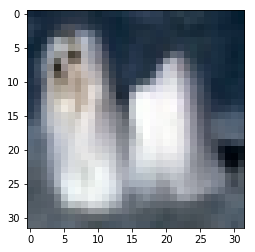

acc: 0.65625
[Test] Step:43 预测分类是 猫，真实分类是 狗


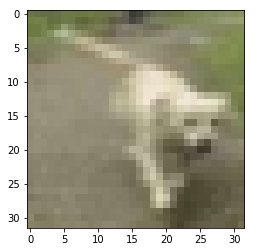

acc: 0.63281
[Test] Step:44 预测分类是 狗，真实分类是 狗


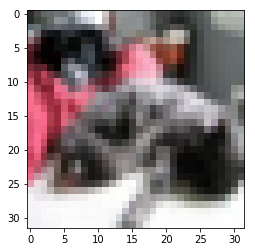

acc: 0.66406
[Test] Step:45 预测分类是 狗，真实分类是 猫


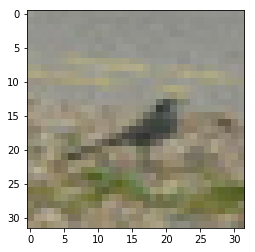

acc: 0.66406
[Test] Step:46 预测分类是 鸟类，真实分类是 鸟类


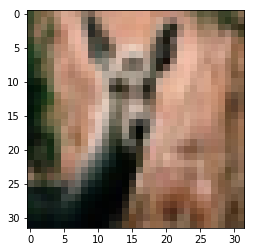

acc: 0.64844
[Test] Step:47 预测分类是 马，真实分类是 鹿


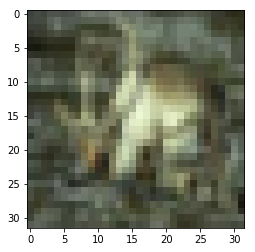

acc: 0.64844
[Test] Step:48 预测分类是 青蛙，真实分类是 鹿


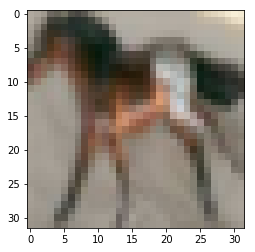

acc: 0.64844
[Test] Step:49 预测分类是 鸟类，真实分类是 马


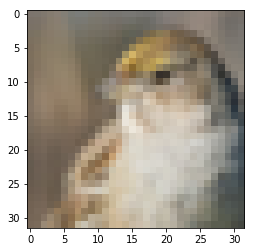

acc: 0.66406
[Test] Step:50 预测分类是 猫，真实分类是 鸟类
 acc: 0.63750


In [7]:
init = tf.global_variables_initializer()
train_steps = 10000
test_steps = 50
acc_val_new = 0
loss_ = []
acc_ = []
step_ = []
num = 0
saver = tf.train.Saver()
#test_batch_data, test_batch_labels = cifar10_input.inputs(eval_data=True, data_dir=CIFAR_DIR, batch_size=batch_size)
with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        start_time = time.time()
        #batch_data, batch_labels = cifar10_input.distorted_inputs(data_dir=CIFAR_DIR,batch_size=batch_size)
        batch_image,batch_data, batch_labels = train_data.next_batch(batch_size)
        loss_val, acc_val,_ = sess.run(
            [loss,accuracy,train_op],feed_dict={
                x: batch_data,y: batch_labels})
        duration = time.time() - start_time

        format_str = ('step %d, loss=%.2f (%.1f examples/sec; %.3f sec/batch),acc: %4.5f')
        if (i+1) % 100 == 0:
            loss_.append(loss_val)
            acc_.append(acc_val)
            step_.append(i)
            examples_per_sec = batch_size / duration
            sec_per_batch = float(duration)
            print(format_str % (i+1, loss_val, examples_per_sec, sec_per_batch,acc_val))
        if acc_val > acc_val_new:
            acc_val_new = acc_val
            saver.save(sess, './model/my-model',write_meta_graph=False)
            if acc_val_new >=0.999:
                print(format_str % (i+1, loss_val, examples_per_sec, sec_per_batch,acc_val))
                break
        num = i
    loss_acc_curve(step_,loss_,acc_,num)
    all_test_acc_val = []
    for j in range(test_steps):
        test_batch_image,test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        #print(test_batch_data.shape)
        
        test_acc_val = sess.run(
            accuracy,feed_dict = {
                x: test_batch_data,y: test_batch_labels})
        sort_prediction = sess.run(
            image_prediction,feed_dict = {
                x: test_batch_data,y: test_batch_labels})
        sort_real = sess.run(
            y,feed_dict = {
                x: test_batch_data,y: test_batch_labels})
        
        image= test_batch_image[0].reshape((3,32,32)) #32 32 3
        image = image.transpose((1,2,0))
        plt.imshow(image)
        plt.show()
        print('acc: %4.5f'%test_acc_val)
        #sort_prediction = tf.nn.top_k(sort_prediction,1)
        #sort_real = tf.nn.top_k(sort_real,1)
        print('[Test] Step:%d 预测分类是 %s，真实分类是 %s'% 
              (j+1 ,sort_image_real(sort_prediction[0]),sort_image_real(sort_real[0])))
        all_test_acc_val.append(test_acc_val)
    test_acc = np.mean(all_test_acc_val)
    print(' acc: %4.5f'% (test_acc))
          
 

In [8]:
#step 2400, loss=0.66 (95.6 examples/sec; 1.339 sec/batch),acc: 0.75000   


"""    
   all_test_acc_val = []
    for j in range(test_steps):
        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        test_acc_val = sess.run(accuracy,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_prediction = sess.run(y_,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_real = sess.run(y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_prediction = tf.nn.top_k(image_prediction,1)
        #image_real = tf.nn.top_k(image_real,1)        
        all_test_acc_val.append(test_acc_val)
    test_acc = np.mean(all_test_acc_val)
    #print('[Test] Step:%d 真实分类是 %s，预测分类是 %s, acc: %4.5f'% (i+1 ,image_prediction.values,image_real.values,test_acc))
    print('[Test] Step:%d , acc: %4.5f'% (i+1 ,test_acc))
     
"""    


"    \n   all_test_acc_val = []\n    for j in range(test_steps):\n        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)\n        test_acc_val = sess.run(accuracy,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        #image_prediction = sess.run(y_,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        #image_real = sess.run(y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        #image_prediction = tf.nn.top_k(image_prediction,1)\n        #image_real = tf.nn.top_k(image_real,1)        \n        all_test_acc_val.append(test_acc_val)\n    test_acc = np.mean(all_test_acc_val)\n    #print('[Test] Step:%d 真实分类是 %s，预测分类是 %s, acc: %4.5f'% (i+1 ,image_prediction.values,image_real.values,test_acc))\n    print('[Test] Step:%d , acc: %4.5f'% (i+1 ,test_acc))\n     \n"

In [9]:
"""
num_examples = 300
    all_test_acc_val = []
    num_inter = int(math.ceil(num_examples / batch_size))
    true_count = 0   
    total_sample_count = num_inter * batch_size
    step = 0
    while step < num_inter:
        #test_batch_data, test_batch_labels= sess.run([test_batch_data, test_batch_labels]   ) 
        #test_batch_data = tf.reshape(test_batch_data,[20,1728]
        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        test_acc_val,count_pred_true =sess.run(
            [accuracy,top_k_op],
            feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_prediction = sess.run(
            image_prediction,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_real = sess.run(
            y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        true_count += np.sum(count_pred_true)
        #print(image_real)
        #print(sess.run(image_prediction.indices))
        sort_prediction = tf.nn.top_k(sort_prediction,1)
        sort_real = tf.nn.top_k(sort_real,1)
        print('[Test] Step:%d 预测分类是 %s，真实分类是 %s'% 
              (step ,sess.run(sort_prediction.indices),sess.run(sort_real.indices)))
        step += 1
    prediction = true_count / total_sample_count
    print ('precision @ 1 = %.3f,acc: %4.5f '
           % (prediction,test_acc_val))
"""

"\nnum_examples = 300\n    all_test_acc_val = []\n    num_inter = int(math.ceil(num_examples / batch_size))\n    true_count = 0   \n    total_sample_count = num_inter * batch_size\n    step = 0\n    while step < num_inter:\n        #test_batch_data, test_batch_labels= sess.run([test_batch_data, test_batch_labels]   ) \n        #test_batch_data = tf.reshape(test_batch_data,[20,1728]\n        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)\n        test_acc_val,count_pred_true =sess.run(\n            [accuracy,top_k_op],\n            feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        sort_prediction = sess.run(\n            image_prediction,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        sort_real = sess.run(\n            y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        true_count += np.sum(count_pred_true)\n        #print(image_real)\n        #print(sess.run(image_prediction.in